##### Copyright 2018 The TensorFlow Authors.

In [20]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 신경 스타일 전송

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
  <td><a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub 모델 보기</a></td>
</table>

이번 튜토리얼에서는 딥 러닝을 사용하여 원하는 이미지를 다른 스타일의 이미지로 구성하는 법을 배워보겠습니다(피카소나 반 고흐처럼 그리기를 희망하나요?). 이 기법은 *Neural Style Transfer*로 알려져 있으며, Leon A. Gatys의 논문 [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)에 잘 기술되어 있습니다.

참고: 이 튜토리얼은 원래 스타일 전송 알고리즘을 보여줍니다. 이는 이미지 콘텐츠를 특정 스타일로 최적화합니다. 최근의 접근 방식에서는 스타일화된 이미지를 직접 생성하도록 모델을 훈련합니다([CycleGAN](./cyclegan.ipynb)과 유사). 이 접근 방식은 훨씬 빠릅니다(최대 1000배).

[TensorFlow Hub](https://tfhub.dev)에서 사전 훈련된 모델을 사용하여 스타일 전송을 간단하게 적용하려면 [임의 이미지 스타일화 모델](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization)을 사용하는 [임의 스타일에 대한 빠른 스타일 전송](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) 튜토리얼을 참조하세요. [TensorFlow Lite](https://www.tensorflow.org/lite)를 사용한 스타일 전송의 예는 [TensorFlow Lite를 사용한 예술적 스타일 전송](https://www.tensorflow.org/lite/examples/style_transfer/overview)을 참조하세요.

신경 스타일 전송은 *콘텐츠* 이미지와 *스타일 참조* 이미지(유명 화가의 작품 등)라는 두 개의 이미지를 가져와서 출력 이미지가 콘텐츠 이미지처럼 보이지만 스타일 참조 이미지의 스타일로 "페인트"되도록 함께 혼합하는 데 사용되는 최적화 기술입니다.

이는 콘텐츠 이미지의 콘텐츠 통계와 스타일 참조 이미지의 스타일 통계가 일치하도록 출력 이미지를 최적화하여 구현됩니다. 이러한 통계는 컨볼루셔널 네트워크를 사용하여 이미지에서 추출됩니다.

예를 들어, 이 개와 Wassily Kandinsky의 Composition 7의 이미지를 살펴보겠습니다.


<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" class="">

([Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), 출처: Wikimedia Commons, 저자: [Elf](https://en.wikipedia.org/wiki/User:Elf). 라이선스: [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en))


<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" class="">

이제 Kandinsky가 이 스타일로만 이 개의 그림을 그리기로 결정했다면 어떤 모습이 될까요? 이렇지 않을까요?


<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" class=""> 

## 설정


### 모듈 구성 및 임포트

In [21]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [22]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.4.0
anyio                        3.6.2
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        22.2.0
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       6.0.0
cachetools                   5.3.0
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           3.0.1
colorama                     0.4.6
comm                         0.1.2
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.6
decorator                    5.1.1
defusedxml                   0.7.1
entrypoints                  0.4
executing                    1.2.0
fastjsonschema               2.16.2
flatbuffers                  23.1.21
f

In [23]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [24]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

이미지를 다운로드받고 스타일 참조 이미지와 콘텐츠 이미지를 선택합니다:

In [25]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

## 입력 시각화

이미지를 불러오는 함수를 정의하고, 최대 이미지 크기를 512개의 픽셀로 제한합니다.

In [26]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

이미지를 출력하기 위한 간단한 함수를 정의합니다:

In [27]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

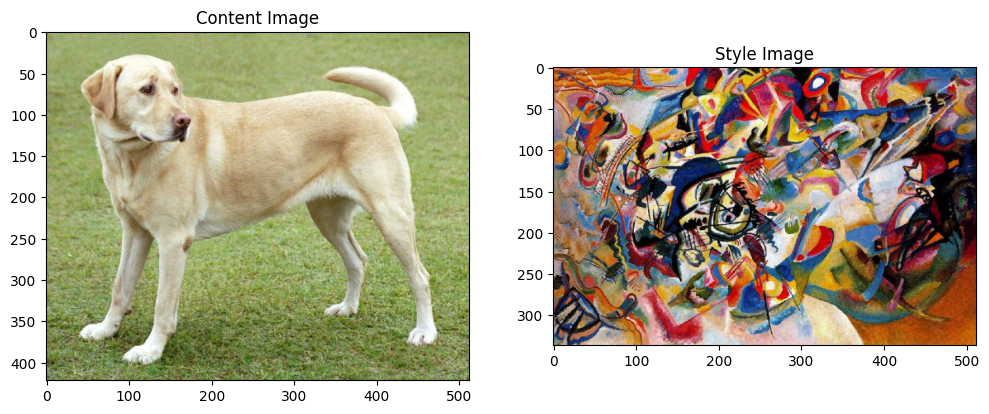

In [28]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## TF-Hub를 통한 빠른 스타일 전이

이 튜토리얼은 이미지 콘텐츠를 특정 스타일로 최적화하는 원래 스타일 전송 알고리즘을 보여줍니다. 세부적으로 들어가기 전에[TensorFlow Hub 모델](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2)이 이 작업을 어떻게 수행하는지 살펴보겠습니다.

Total time: 3.4


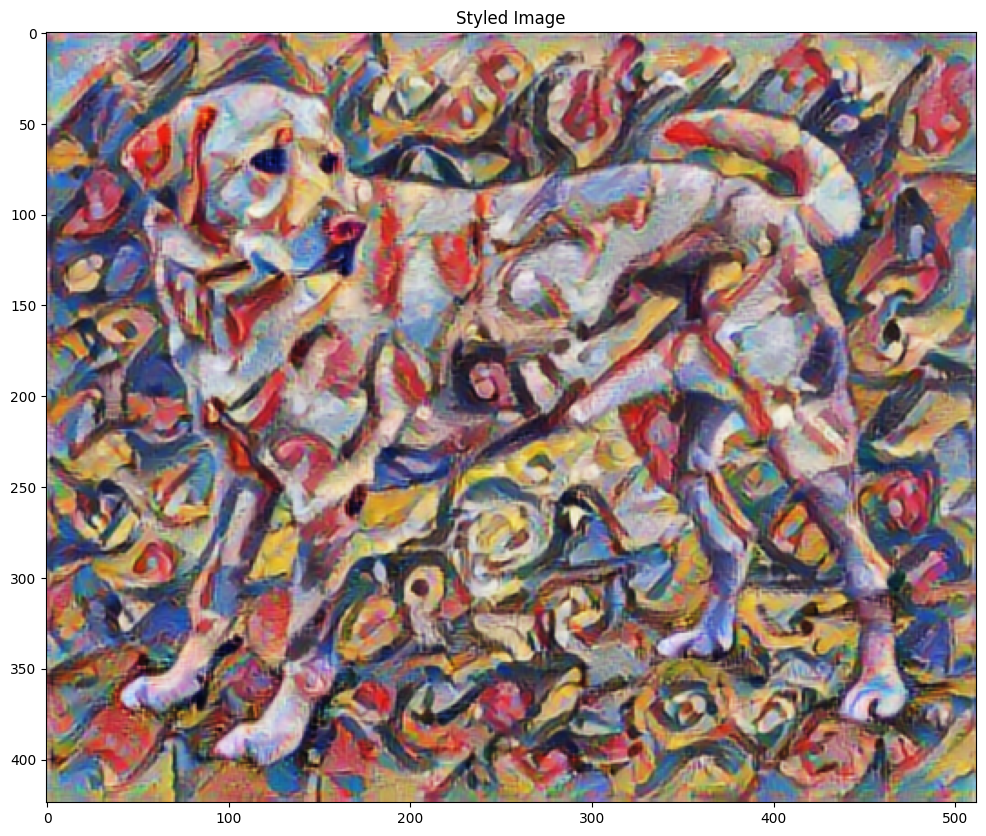

In [30]:
import tensorflow_hub as hub
import time
start = time.time()

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

end = time.time()
print("Total time: {:.1f}".format(end-start))
imshow(stylized_image, 'Styled Image')

## 콘텐츠와 스타일 표현 정의하기

이미지의 콘텐츠와 스타일 표현(representation)을 얻기 위해, 모델의 몇 가지 중간층들을 살펴볼 것입니다. 모델의 입력층부터 시작해서, 처음 몇 개의 층은 선분이나 질감과 같은 이미지 내의 저차원적 특성에 반응합니다. 반면, 네트워크가 깊어지면 최종 몇 개의 층은 *바퀴*나 *눈*과 같은 고차원적 특성들을 나타냅니다. 이번 경우, 우리는 사전학습된 이미지 분류 네트워크인 VGG19 네트워크의 구조를 사용할 것입니다. 이 중간층들은 이미지에서 콘텐츠와 스타일 표현을 정의하는 데 필요합니다. 입력 이미지가 주어졌을때, 스타일 전이 알고리즘은 이 중간층들에서 콘텐츠와 스타일에 해당하는 타깃 표현들을 일치시키려고 시도할 것입니다.


[VGG19](https://keras.io/applications/#vgg19) 모델을 불러오고, 작동 여부를 확인하기 위해 이미지에 적용시켜봅시다:

In [10]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 [==============================] - 3s 0us/step


TensorShape([1, 1000])

In [11]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('Labrador_retriever', 0.49317136),
 ('golden_retriever', 0.23665282),
 ('kuvasz', 0.036357533),
 ('Chesapeake_Bay_retriever', 0.024182757),
 ('Greater_Swiss_Mountain_dog', 0.01864606)]

이제 분류층을 제외한 `VGG19` 모델을 불러오고, 각 층의 이름을 출력해봅니다.

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


이미지의 스타일과 콘텐츠를 나타내기 위한 모델의 중간층들을 선택합니다:


In [13]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### 스타일과 콘텐츠를 위한 중간층

그렇다면 사전훈련된 이미지 분류 네트워크 속에 있는 중간 출력으로 어떻게 스타일과 콘텐츠 표현을 정의할 수 있을까요?

고수준에서 보면 (네트워크의 훈련 목적인) 이미지 분류를 수행하기 위해서는 네트워크가 반드시 이미지를 이해햐야 합니다. 이는 미가공 이미지를 입력으로 받아 픽셀값들을 이미지 내에 존재하는 특성(feature)들에 대한 복합적인 이해로 변환할 수 있는 내부 표현(internal representation)을 만드는 작업이 포함됩니다.

또한 부분적으로 왜 합성곱(convolutional) 신경망의 일반화(generalize)가 쉽게 가능한지를 나타냅니다. 즉, 합성곱 신경망은 배경잡음(background noise)과 기타잡음(nuisances)에 상관없이 (고양이와 강아지와 같이)클래스 안에 있는 불변성(invariance)과 특징을 포착할 수 있습니다. 따라서 미가공 이미지의 입력과 분류 레이블(label)의 출력 중간 어딘가에서 모델은 복합 특성(complex feature) 추출기의 역할을 수행합니다. 그러므로, 모델의 중간층에 접근함으로써 입력 이미지의 콘텐츠와 스타일을 추출할 수 있습니다.

## 모델 만들기

`tf.keras.applications`에서 제공하는 모델들은 케라스 함수형 API을 통해 중간층에 쉽게 접근할 수 있도록 구성되어있습니다.

함수형 API를 이용해 모델을 정의하기 위해서는 모델의 입력과 출력을 지정합니다:

`model = Model(inputs, outputs)`

아래의 함수는 중간층들의 결과물을 배열 형태로 출력하는 `VGG19` 모델을 반환합니다:

In [14]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

위 함수를 이용해 모델을 만들어봅시다:

In [15]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



## 스타일 계산하기

이미지의 콘텐츠는 중간층들의 특성 맵(feature map)의 값들로 표현됩니다.

이미지의 스타일은 각 특성 맵의 평균과 피쳐맵들 사이의 상관관계로 설명할 수 있습니다. 이런 정보를 담고 있는 그람 행렬(Gram matrix)은 각 위치에서 특성 벡터(feature vector)끼리의 외적을 구한 후,평균값을 냄으로써 구할 수 있습니다. 주어진 층에 대한 그람 행렬은 다음과 같이 계산할 수 있습니다:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

이 식은 `tf.linalg.einsum` 함수를 통해 쉽게 계산할 수 있습니다:

In [16]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## 스타일과 콘텐츠 추출하기


스타일과 콘텐츠 텐서를 반환하는 모델을 만듭시다.

In [17]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

이미지가 입력으로 주어졌을때, 이 모델은 `style_layers`의 스타일과 `content_layers`의 콘텐츠에 대한 그람 행렬을 출력합니다:

In [18]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522845
    max:  28014.555
    mean:  263.79022

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.49
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.5
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.36
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.879
    mean:  13.764149


## 경사하강법 실행

이제 스타일과 콘텐츠 추출기를 사용해 스타일 전이 알고리즘을 구현할 차례입니다. 타깃에 대한 입력 이미지의 평균 제곱 오차를 계산한 후, 오차값들의 가중합을 구합니다.

스타일과 콘텐츠의 타깃값을 지정합니다:

In [19]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

최적화시킬 이미지를 담을 `tf.Variable`을 정의하고 콘텐츠 이미지로 초기화합니다. (이때 `tf.Variable`는 콘텐츠 이미지와 크기가 같아야 합니다.):

In [20]:
image = tf.Variable(content_image)

픽셀 값이 실수이므로 0과 1 사이로 클리핑하는 함수를 정의합니다:

In [21]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

옵티마이저를 생성합니다. 참조 연구에서는 LBFGS를 추천하지만, `Adam`도 충분히 적합합니다:

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

최적화를 진행하기 위해, 전체 오차를 콘텐츠와 스타일 오차의 가중합으로 정의합니다:

In [23]:
style_weight=1e-2
content_weight=1e4

In [24]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

`tf.GradientTape`를 사용해 이미지를 업데이트합니다.

In [25]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

구현한 알고리즘을 시험해보기 위해 몇 단계를 돌려봅시다:

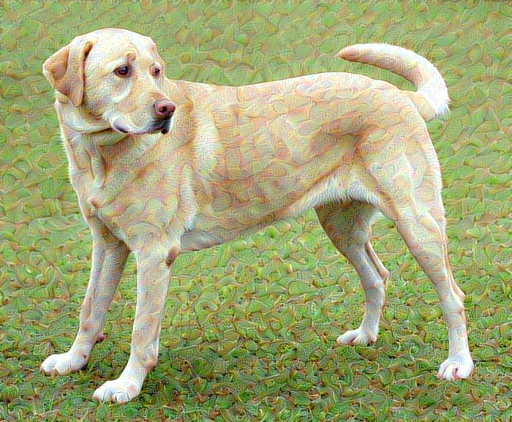

In [26]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

잘 작동하는 것을 확인했으니, 더 오랫동안 최적화를 진행해봅니다:

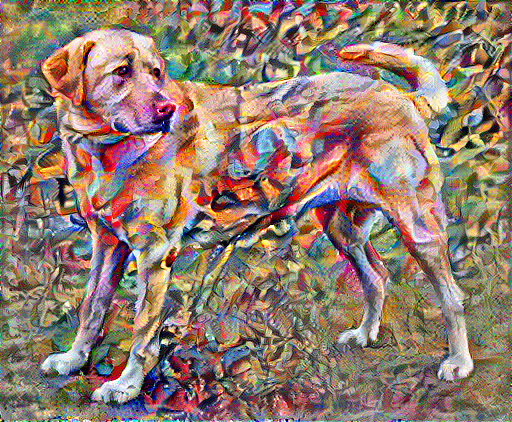

Train step: 1000
Total time: 82.3


In [27]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

## 총 변위 손실

이 기본 구현 방식의 한 가지 단점은 많은 고주파 아티팩(high frequency artifact)가 생겨난다는 점 입니다. 아티팩 생성을 줄이기 위해서는 이미지의 고주파 구성 요소에 대한 레귤러리제이션(regularization) 항을 추가해야 합니다. 스타일 전이에서는 이 변형된 오차값을 *총 변위 손실(total variation loss)*라고 합니다:

In [28]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

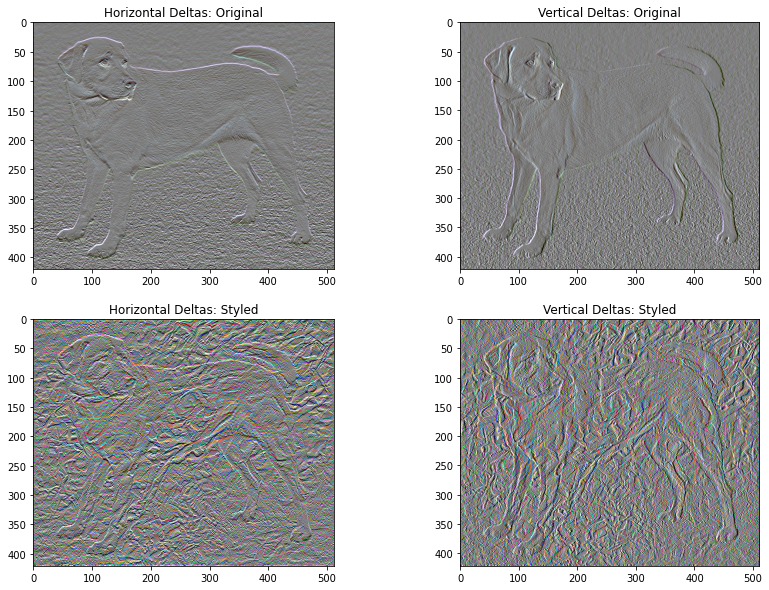

In [29]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

위 이미지들은 고주파 구성 요소가 늘어났다는 것을 보여줍니다.

한 가지 흥미로운 사실은 고주파 구성 요소가 경계선 탐지기의 일종이라는 점입니다. 이를테면 소벨 경계선 탐지기(Sobel edge detector)를 사용하면 유사한 출력을 얻을 수 있습니다:

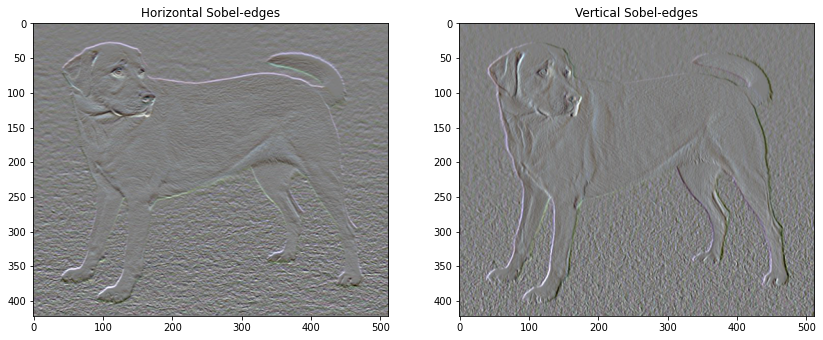

In [30]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

정규화 오차는 각 값의 절대값의 합으로 표현됩니다:

In [31]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [32]:
total_variation_loss(image).numpy()

149480.8

식이 잘 계산된다는 것을 확인할 수 있습니다. 하지만 다행히도 텐서플로에는 이미 표준 함수가 내장되어 있기 직접 오차식을 구현할 필요는 없습니다:

In [33]:
tf.image.total_variation(image).numpy()

array([149480.8], dtype=float32)

## 다시 최적화하기

`total_variation_loss`를 위한 가중치를 정의합니다:

In [34]:
total_variation_weight=30

이제 이 가중치를 `train_step` 함수에서 사용합니다:

In [35]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

이미지 변수와 옵티마이저를 다시 초기화합니다.

In [36]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

최적화를 수행합니다:

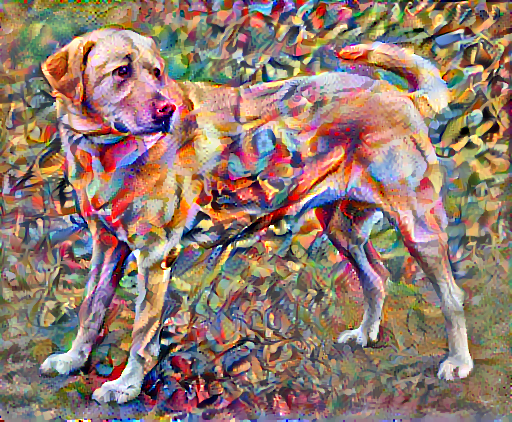

Train step: 1000
Total time: 83.5


In [37]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

마지막으로, 결과물을 저장합니다:

In [38]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 자세히 알아보기

이 튜토리얼은 원래 스타일 전송 알고리즘을 보여줍니다. 스타일 전송의 간단한 적용에 대해서는 이 [튜토리얼](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization)을 확인하여 [TensorFlow Hub](https://tfhub.dev)에서 임의의 이미지 스타일 전송 모델을 사용하는 방법에 대해 자세히 알아보세요.